In [1]:
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import zipfile
import seaborn as sns
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline


In [2]:

BASE_DIR = '/kaggle/input/utkface/UTKFace'
age_labels = []
gender_labels = []
image_paths = []

image_filenames = os.listdir(BASE_DIR)
random.shuffle(image_filenames)

for image in tqdm(image_filenames):
  image_path = os.path.join(BASE_DIR, image)
  img_components = image.split('_')
  age_label = int(img_components[0])
  gender_label = int(img_components[1])

  # Append the image_path, age_label, and gender_label
  age_labels.append(age_label)
  gender_labels.append(gender_label)
  image_paths.append(image_path)

100%|██████████| 23708/23708 [00:00<00:00, 250775.64it/s]


In [3]:
print(f'Number of age_labels: {len(age_labels)}, Number of gender_labels: {len(gender_labels)}, Number of image_paths: {len(image_paths)}')

Number of age_labels: 23708, Number of gender_labels: 23708, Number of image_paths: 23708


In [4]:
gender_mapping = {
    1: 'Female',
    0: 'Male'
}

In [5]:
import pandas as pd 
df = pd.DataFrame()
df['image_path'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head(5)

,image_path,age,gender
0,/kaggle/input/utkface/UTKFace/85_0_2_201701112...,85,0
1,/kaggle/input/utkface/UTKFace/71_1_0_201701101...,71,1
2,/kaggle/input/utkface/UTKFace/16_1_1_201701140...,16,1
3,/kaggle/input/utkface/UTKFace/26_1_0_201701171...,26,1
4,/kaggle/input/utkface/UTKFace/57_0_3_201701192...,57,0


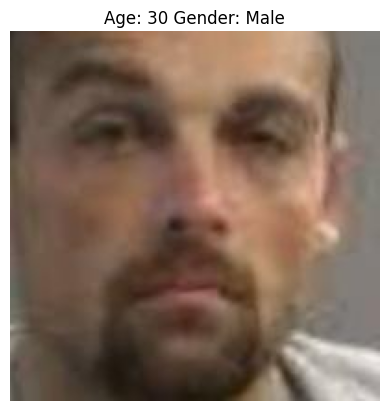

In [6]:
from PIL import Image

rand_index = random.randint(0, len(image_paths))
age = df['age'][rand_index]
gender = df['gender'][rand_index]
IMG = Image.open(df['image_path'][rand_index])
plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
plt.axis('off')
plt.imshow(IMG)

<Axes: xlabel='age', ylabel='Density'>

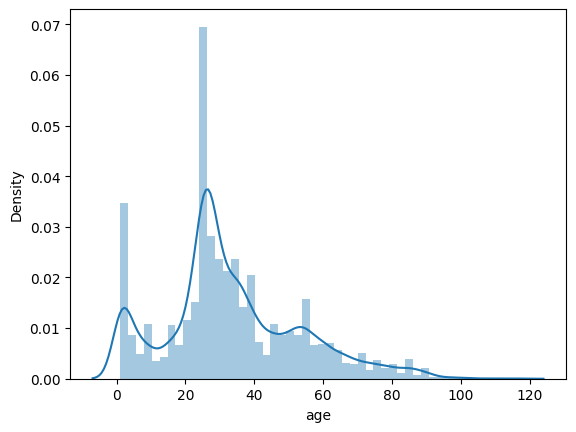

In [7]:
 sns.distplot(df['age'])

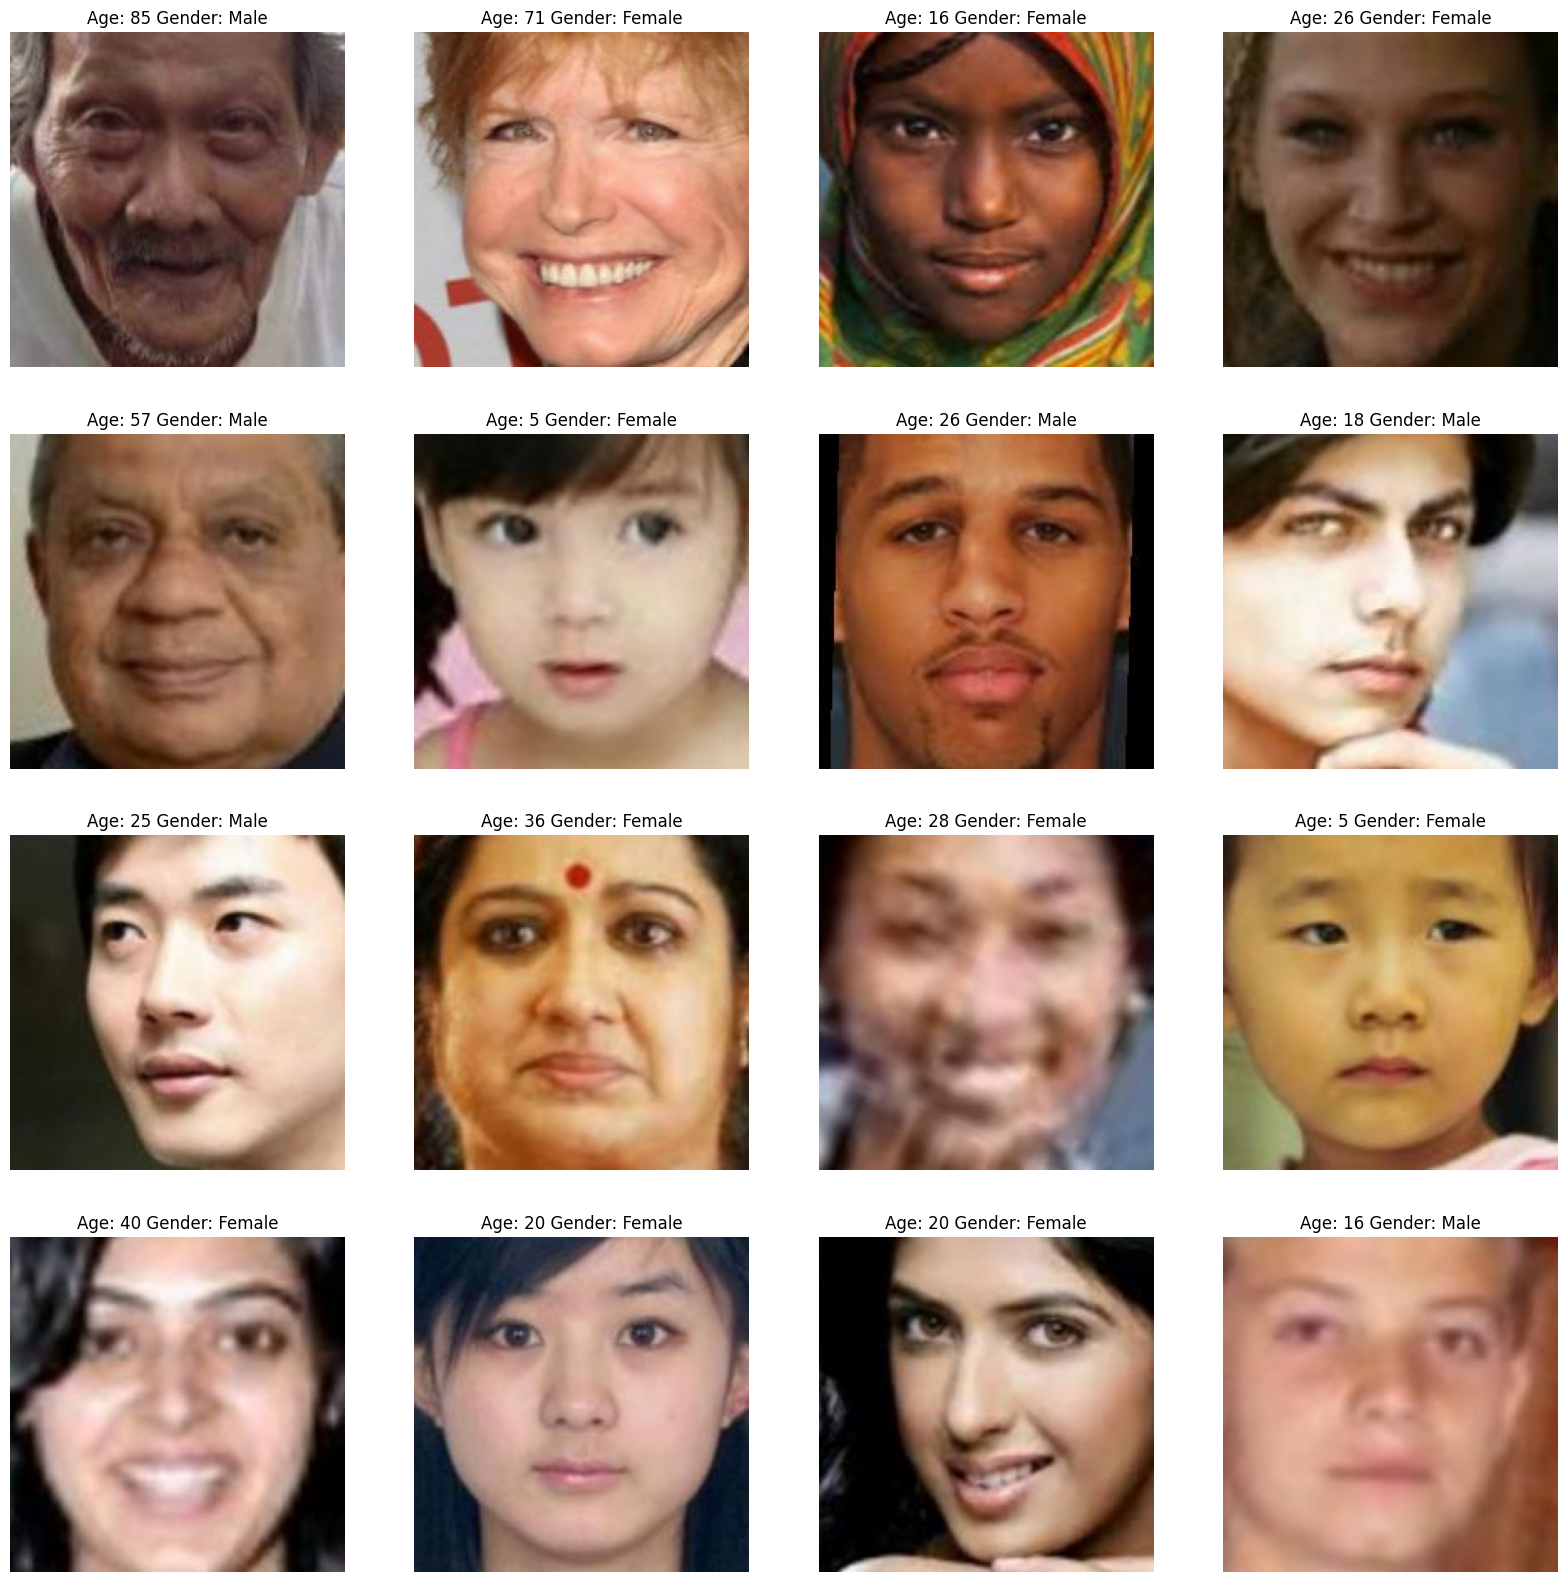

In [8]:
plt.figure(figsize=(20, 20))
samples = df.iloc[0:16]

for index, sample, age, gender in samples.itertuples():
    plt.subplot(4, 4, index + 1)
    img = load_img(sample)
    img = np.array(img)
    plt.axis('off')
    plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
    plt.imshow(img)

In [9]:
def extract_image_features(images):
    features = list()

    for image in tqdm(images):
        img = load_img(image,color_mode='grayscale')
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [10]:
X = extract_image_features(df['image_path'])

100%|██████████| 23708/23708 [03:24<00:00, 115.69it/s]


In [11]:
X.shape

(23708, 128, 128, 1)

In [12]:
X = X / 255.0

In [13]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [14]:
    input_shape = (128, 128, 1)

In [15]:
 def create_model(input_shape):
    inputs = Input(input_shape)
    conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
    max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
    conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
    max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
    conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
    max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
    conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
    max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)
    conv_5 = Conv2D(512, kernel_size=(3, 3), activation='relu')(max_4)
    max_5 = MaxPooling2D(pool_size=(2, 2))(conv_5)

    flatten = Flatten()(max_5)

    # fully connected layers
    dense_1 = Dense(256, activation='relu')(flatten)
    dense_2 = Dense(256, activation='relu')(flatten)

    dropout_1 = Dropout(0.3)(dense_1)
    dropout_2 = Dropout(0.3)(dense_2)

    output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
    output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)

    model = Model(inputs=[inputs], outputs=[output_1, output_2])

    model.compile(loss={'gender_out': 'binary_crossentropy', 'age_out': 'mae'},
                  optimizer='adam',
                  metrics={'gender_out': 'accuracy', 'age_out': 'mae'})
    return model


# # Assuming your input shape is (128, 128, 1) based on your previous code
 input_shape = (128, 128, 1)

# Create the model
 model = create_model(input_shape)
print(model.summary())



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 14,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 12, 12,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 6, 6, 256) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 4, 4, 512) │  1,180,160 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 2, 2, 512) │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    524,544 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_out (Dense)  │ (None, 1)         │        257 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_out (Dense)     │ (None, 1)         │        257 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,617,602 (9.99 MB)

 Trainable params: 2,617,602 (9.99 MB)

 Non-trainable params: 0 (0.00 B)

None


In [16]:
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 14,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 12, 12,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 6, 6, 256) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 4, 4, 512) │  1,180,160 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 2, 2, 512) │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    524,544 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_out (Dense)  │ (None, 1)         │        257 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_out (Dense)     │ (None, 1)         │        257 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,617,602 (9.99 MB)

 Trainable params: 2,617,602 (9.99 MB)

 Non-trainable params: 0 (0.00 B)

None


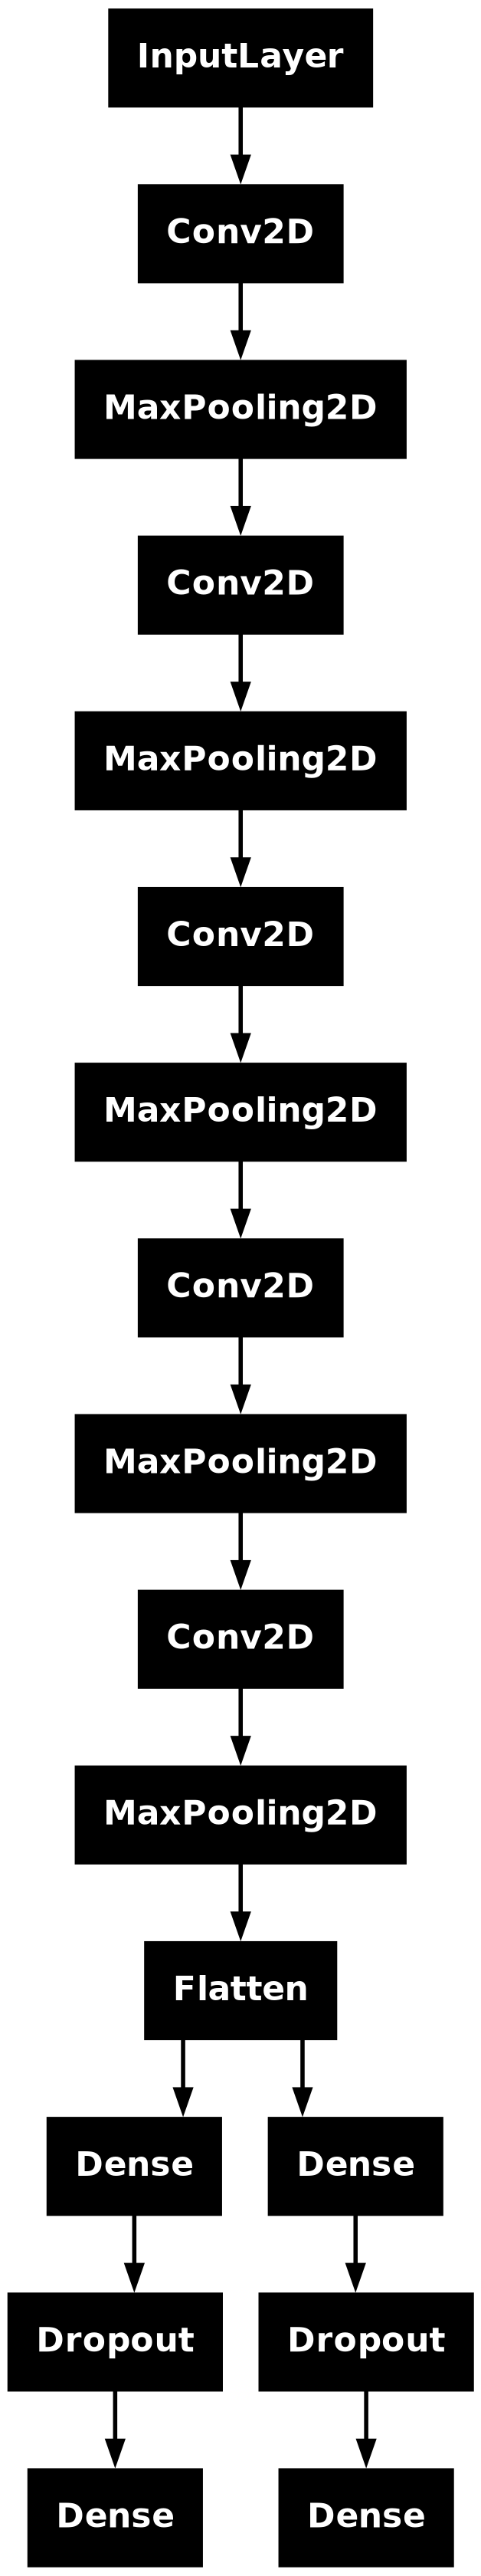

In [17]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [18]:
history = model.fit(x=X,
                    y={'gender_out': y_gender, 'age_out': y_age},
                    batch_size=32,
                    epochs=40,
                    validation_split=0.2)

Epoch 1/40


I0000 00:00:1725290068.779245      84 service.cc:145] XLA service 0x7b907c002470 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725290068.779312      84 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 15/593 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - age_out_mae: 28.4016 - gender_out_accuracy: 0.4721 - loss: 29.2237

I0000 00:00:1725290075.041543      84 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


593/593 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - age_out_mae: 17.2795 - gender_out_accuracy: 0.4981 - loss: 18.0142 - val_age_out_mae: 13.9341 - val_gender_out_accuracy: 0.5196 - val_loss: 14.6225
Epoch 2/40
593/593 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - age_out_mae: 12.9723 - gender_out_accuracy: 0.6259 - loss: 13.6082 - val_age_out_mae: 9.8980 - val_gender_out_accuracy: 0.7488 - val_loss: 10.4312
Epoch 3/40
593/593 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - age_out_mae: 9.3496 - gender_out_accuracy: 0.7401 - loss: 9.8772 - val_age_out_mae: 8.6314 - val_gender_out_accuracy: 0.7737 - val_loss: 9.1032
Epoch 4/40
593/593 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - age_out_mae: 8.2354 - gender_out_accuracy: 0.7851 - loss: 8.6874 - val_age_out_mae: 7.5922 - val_gender_out_accuracy: 0.8121 - val_loss: 7.9875
Epoch 5/40
593/593 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - age_out_mae: 7.6072 - gender_out_accuracy: 0.8177 - loss: 8.0117 - val_age_out_mae: 6.9439 - val_gender_out_accuracy: 0.8115 - val_loss: 7.3447
Epoch 6/

KeyError: 'val_gender_outloss'

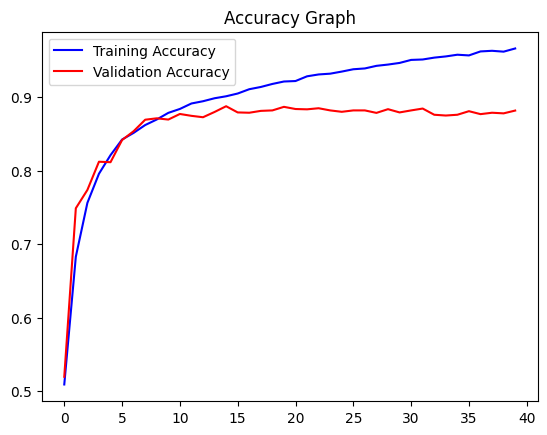

<Figure size 640x480 with 0 Axes>

In [19]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_gender_outloss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [ ]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [20]:
def get_image_features(image):
  img = load_img(image,color_mode='grayscale')
  img = img.resize((128, 128), Image.ANTIALIAS)
  img = np.array(img)
  img = img.reshape(1, 128, 128, 1)
  img = img / 255.0
  return img

In [ ]:
img_to_test = '/kaggle/input/testimage/Harry_Potter_character_poster.jpg.jpg'
pred = model.predict(features)
gender = gender_mapping[round(pred[0][0][0])]
age = round(pred[1][0][0])

plt.title(f'Predicted Age: {age} Predicted Gender: {gender}')
plt.axis('off')
plt.imshow(np.array(load_img(img_to_test)))